# ResNet50 model

In [1]:
import torch
import torch.nn as nn

class block(nn.Module):
  # Identity downsample for conv layer for projection shortcut
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(block,self).__init__()
    self.expansion = 4

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

    self.relu = nn.ReLU()

    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x


class ResNet(nn.Module):
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64 # Since, in resnet the input channel starts from 64

    # For Conv1 (image_channels in start is 1(GrayScale) --> after conv layer 64)
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()

    # For Maxpool (channel 64 remains constant, spatial dimension decreases in half)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet layers (In ResNet50, there are 4 layers where, in each layer the blocks are repeated [3,4,6,3] times)
    self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
    self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
    self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
    self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

    # For Avg. Pooling such that the output is 2048x1x1 so Adaptive Pooling applied accordingly
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    # For final fully connected layer
    self.fc = nn.Linear(2048*1*1, num_classes)

  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc(x)
    return x

  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride!=1 or self.in_channels != out_channels*4 :
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                    stride=stride),
                                          nn.BatchNorm2d(out_channels*4))

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels = out_channels*4

    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

# Creating the model
def ResNet50(image_channels=3, num_classes=1000):
  return ResNet(block, [3,4,6,3], image_channels, num_classes)


# Validating the model with example (1 image with shape=3x224x224)
model = ResNet50(image_channels=3, num_classes=5)
x = torch.randn(5, 3, 224, 224)
# print(model(x).shape) # Output: torch.Size([5, 5])

# Training

In [2]:
import os
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"

people = ['Ben Afflek', 'Elton John', 'Jerry Seinfield', 'Madonna', 'Mindy Kaling']
DIR = r'/content/drive/MyDrive/Faces/train' # Directory of the training images

haar_cascade = cv.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

dataset = [] # List of tuples (image, label)
def create_train():
    """
    Loops over every folder in the base folder(training folder).
    And inside that folder, loop over every image and grab that face in that image
    and add it to the training set.
    """
    for person in people:
        """Loop over every folder"""
        path = os.path.join(DIR, person) # Path to the folder of the person
        label = people.index(person) # Label of the person

        for img in os.listdir(path):
            """Loop over every image"""
            img_path = os.path.join(path, img) # Path to the image

            img_array = cv.imread(img_path) # Read the image

            faces_rect = haar_cascade.detectMultiScale(img_array, scaleFactor=1.1, minNeighbors=4)

            for (x,y,w,h) in faces_rect:
                """Grab the face in the image"""
                faces_roi = img_array[y:y+h, x:x+w] # Region of interest
                faces_roi = cv.resize(faces_roi, (224,224), interpolation=cv.INTER_NEAREST)
                dataset.append((faces_roi, label))

# Create the training set
create_train()

# Convert the images to tensors
dataset = [(ToTensor()(img), label) for img, label in dataset]

# Create the training loader
from torch.utils.data import DataLoader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

# Instantiate the model
model = ResNet50(image_channels=3, num_classes=5).to(device)

# Loss and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
from tqdm import tqdm
import time

for epoch in tqdm(range(50), desc='Epochs'):

    model.train() # Set the model to training mode
    start_time = time.time() # Start time of the epoch

    running_loss = 0.0
    running_corrects = 0

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Calculate epoch loss and accuracy for training data
    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)

    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Print the loss and accuracy
    print(f"Epoch [{epoch+1}/{50}], "
        f"Overfit Loss: {epoch_loss:.4f}, Overfit Accuracy: {epoch_acc:.4f}")

# Save the model
torch.save(model.state_dict(), 'resnet50.pth')


Epochs:   2%|▏         | 1/50 [00:09<07:31,  9.21s/it]

Epoch 1 completed in 9.20 seconds
Epoch [1/50], Overfit Loss: 2.7642, Overfit Accuracy: 0.2600


Epochs:   4%|▍         | 2/50 [00:10<03:32,  4.43s/it]

Epoch 2 completed in 1.07 seconds
Epoch [2/50], Overfit Loss: 1.8284, Overfit Accuracy: 0.3000


Epochs:   6%|▌         | 3/50 [00:11<02:16,  2.90s/it]

Epoch 3 completed in 1.07 seconds
Epoch [3/50], Overfit Loss: 1.5788, Overfit Accuracy: 0.3100


Epochs:   8%|▊         | 4/50 [00:12<01:40,  2.18s/it]

Epoch 4 completed in 1.07 seconds
Epoch [4/50], Overfit Loss: 1.5385, Overfit Accuracy: 0.3200


Epochs:  10%|█         | 5/50 [00:13<01:20,  1.79s/it]

Epoch 5 completed in 1.07 seconds
Epoch [5/50], Overfit Loss: 1.6962, Overfit Accuracy: 0.4100


Epochs:  12%|█▏        | 6/50 [00:14<01:08,  1.55s/it]

Epoch 6 completed in 1.07 seconds
Epoch [6/50], Overfit Loss: 1.6597, Overfit Accuracy: 0.3700


Epochs:  14%|█▍        | 7/50 [00:15<01:00,  1.40s/it]

Epoch 7 completed in 1.07 seconds
Epoch [7/50], Overfit Loss: 1.4163, Overfit Accuracy: 0.4100


Epochs:  16%|█▌        | 8/50 [00:16<00:54,  1.30s/it]

Epoch 8 completed in 1.07 seconds
Epoch [8/50], Overfit Loss: 1.2429, Overfit Accuracy: 0.5100


Epochs:  18%|█▊        | 9/50 [00:17<00:50,  1.23s/it]

Epoch 9 completed in 1.07 seconds
Epoch [9/50], Overfit Loss: 1.2046, Overfit Accuracy: 0.5200


Epochs:  20%|██        | 10/50 [00:18<00:47,  1.19s/it]

Epoch 10 completed in 1.07 seconds
Epoch [10/50], Overfit Loss: 1.1950, Overfit Accuracy: 0.5900


Epochs:  22%|██▏       | 11/50 [00:20<00:45,  1.16s/it]

Epoch 11 completed in 1.08 seconds
Epoch [11/50], Overfit Loss: 1.1632, Overfit Accuracy: 0.5400


Epochs:  24%|██▍       | 12/50 [00:21<00:43,  1.14s/it]

Epoch 12 completed in 1.08 seconds
Epoch [12/50], Overfit Loss: 1.0095, Overfit Accuracy: 0.6400


Epochs:  26%|██▌       | 13/50 [00:22<00:41,  1.12s/it]

Epoch 13 completed in 1.08 seconds
Epoch [13/50], Overfit Loss: 0.8866, Overfit Accuracy: 0.6300


Epochs:  28%|██▊       | 14/50 [00:23<00:40,  1.11s/it]

Epoch 14 completed in 1.07 seconds
Epoch [14/50], Overfit Loss: 0.9306, Overfit Accuracy: 0.6500


Epochs:  30%|███       | 15/50 [00:24<00:38,  1.11s/it]

Epoch 15 completed in 1.08 seconds
Epoch [15/50], Overfit Loss: 0.8052, Overfit Accuracy: 0.7300


Epochs:  32%|███▏      | 16/50 [00:25<00:37,  1.10s/it]

Epoch 16 completed in 1.08 seconds
Epoch [16/50], Overfit Loss: 0.9423, Overfit Accuracy: 0.5900


Epochs:  34%|███▍      | 17/50 [00:26<00:36,  1.10s/it]

Epoch 17 completed in 1.07 seconds
Epoch [17/50], Overfit Loss: 0.8185, Overfit Accuracy: 0.7000


Epochs:  36%|███▌      | 18/50 [00:27<00:35,  1.09s/it]

Epoch 18 completed in 1.08 seconds
Epoch [18/50], Overfit Loss: 0.9646, Overfit Accuracy: 0.6600


Epochs:  38%|███▊      | 19/50 [00:28<00:33,  1.09s/it]

Epoch 19 completed in 1.08 seconds
Epoch [19/50], Overfit Loss: 0.7224, Overfit Accuracy: 0.7400


Epochs:  40%|████      | 20/50 [00:29<00:32,  1.09s/it]

Epoch 20 completed in 1.08 seconds
Epoch [20/50], Overfit Loss: 0.6912, Overfit Accuracy: 0.7000


Epochs:  42%|████▏     | 21/50 [00:30<00:31,  1.10s/it]

Epoch 21 completed in 1.08 seconds
Epoch [21/50], Overfit Loss: 0.4992, Overfit Accuracy: 0.8400


Epochs:  44%|████▍     | 22/50 [00:32<00:30,  1.10s/it]

Epoch 22 completed in 1.09 seconds
Epoch [22/50], Overfit Loss: 0.5093, Overfit Accuracy: 0.8200


Epochs:  46%|████▌     | 23/50 [00:33<00:29,  1.10s/it]

Epoch 23 completed in 1.09 seconds
Epoch [23/50], Overfit Loss: 0.6005, Overfit Accuracy: 0.8000


Epochs:  48%|████▊     | 24/50 [00:34<00:28,  1.10s/it]

Epoch 24 completed in 1.09 seconds
Epoch [24/50], Overfit Loss: 0.5922, Overfit Accuracy: 0.7500


Epochs:  50%|█████     | 25/50 [00:35<00:27,  1.10s/it]

Epoch 25 completed in 1.08 seconds
Epoch [25/50], Overfit Loss: 0.5268, Overfit Accuracy: 0.8000


Epochs:  52%|█████▏    | 26/50 [00:36<00:26,  1.10s/it]

Epoch 26 completed in 1.08 seconds
Epoch [26/50], Overfit Loss: 0.5926, Overfit Accuracy: 0.8100


Epochs:  54%|█████▍    | 27/50 [00:37<00:25,  1.10s/it]

Epoch 27 completed in 1.09 seconds
Epoch [27/50], Overfit Loss: 0.5852, Overfit Accuracy: 0.7400


Epochs:  56%|█████▌    | 28/50 [00:38<00:24,  1.10s/it]

Epoch 28 completed in 1.08 seconds
Epoch [28/50], Overfit Loss: 0.4731, Overfit Accuracy: 0.8500


Epochs:  58%|█████▊    | 29/50 [00:39<00:23,  1.10s/it]

Epoch 29 completed in 1.09 seconds
Epoch [29/50], Overfit Loss: 0.5629, Overfit Accuracy: 0.7700


Epochs:  60%|██████    | 30/50 [00:40<00:22,  1.10s/it]

Epoch 30 completed in 1.09 seconds
Epoch [30/50], Overfit Loss: 0.4693, Overfit Accuracy: 0.8000


Epochs:  62%|██████▏   | 31/50 [00:41<00:20,  1.10s/it]

Epoch 31 completed in 1.08 seconds
Epoch [31/50], Overfit Loss: 0.4906, Overfit Accuracy: 0.8200


Epochs:  64%|██████▍   | 32/50 [00:43<00:19,  1.10s/it]

Epoch 32 completed in 1.08 seconds
Epoch [32/50], Overfit Loss: 0.3116, Overfit Accuracy: 0.8900


Epochs:  66%|██████▌   | 33/50 [00:44<00:18,  1.10s/it]

Epoch 33 completed in 1.08 seconds
Epoch [33/50], Overfit Loss: 0.1914, Overfit Accuracy: 0.9100


Epochs:  68%|██████▊   | 34/50 [00:45<00:17,  1.10s/it]

Epoch 34 completed in 1.09 seconds
Epoch [34/50], Overfit Loss: 0.3410, Overfit Accuracy: 0.8700


Epochs:  70%|███████   | 35/50 [00:46<00:16,  1.10s/it]

Epoch 35 completed in 1.09 seconds
Epoch [35/50], Overfit Loss: 0.3460, Overfit Accuracy: 0.9000


Epochs:  72%|███████▏  | 36/50 [00:47<00:15,  1.11s/it]

Epoch 36 completed in 1.10 seconds
Epoch [36/50], Overfit Loss: 0.3618, Overfit Accuracy: 0.8600


Epochs:  74%|███████▍  | 37/50 [00:48<00:14,  1.11s/it]

Epoch 37 completed in 1.09 seconds
Epoch [37/50], Overfit Loss: 0.3656, Overfit Accuracy: 0.8300


Epochs:  76%|███████▌  | 38/50 [00:49<00:13,  1.11s/it]

Epoch 38 completed in 1.09 seconds
Epoch [38/50], Overfit Loss: 0.2777, Overfit Accuracy: 0.9100


Epochs:  78%|███████▊  | 39/50 [00:50<00:12,  1.11s/it]

Epoch 39 completed in 1.10 seconds
Epoch [39/50], Overfit Loss: 0.2090, Overfit Accuracy: 0.9700


Epochs:  80%|████████  | 40/50 [00:51<00:11,  1.11s/it]

Epoch 40 completed in 1.10 seconds
Epoch [40/50], Overfit Loss: 0.4753, Overfit Accuracy: 0.8600


Epochs:  82%|████████▏ | 41/50 [00:53<00:09,  1.11s/it]

Epoch 41 completed in 1.10 seconds
Epoch [41/50], Overfit Loss: 0.2894, Overfit Accuracy: 0.9200


Epochs:  84%|████████▍ | 42/50 [00:54<00:08,  1.11s/it]

Epoch 42 completed in 1.09 seconds
Epoch [42/50], Overfit Loss: 0.3883, Overfit Accuracy: 0.8700


Epochs:  86%|████████▌ | 43/50 [00:55<00:07,  1.11s/it]

Epoch 43 completed in 1.09 seconds
Epoch [43/50], Overfit Loss: 0.2486, Overfit Accuracy: 0.9100


Epochs:  88%|████████▊ | 44/50 [00:56<00:06,  1.11s/it]

Epoch 44 completed in 1.10 seconds
Epoch [44/50], Overfit Loss: 0.1422, Overfit Accuracy: 0.9500


Epochs:  90%|█████████ | 45/50 [00:57<00:05,  1.11s/it]

Epoch 45 completed in 1.10 seconds
Epoch [45/50], Overfit Loss: 0.2208, Overfit Accuracy: 0.9200


Epochs:  92%|█████████▏| 46/50 [00:58<00:04,  1.11s/it]

Epoch 46 completed in 1.11 seconds
Epoch [46/50], Overfit Loss: 0.2078, Overfit Accuracy: 0.9300


Epochs:  94%|█████████▍| 47/50 [00:59<00:03,  1.12s/it]

Epoch 47 completed in 1.11 seconds
Epoch [47/50], Overfit Loss: 0.2178, Overfit Accuracy: 0.9300


Epochs:  96%|█████████▌| 48/50 [01:00<00:02,  1.12s/it]

Epoch 48 completed in 1.10 seconds
Epoch [48/50], Overfit Loss: 0.2566, Overfit Accuracy: 0.9200


Epochs:  98%|█████████▊| 49/50 [01:01<00:01,  1.12s/it]

Epoch 49 completed in 1.10 seconds
Epoch [49/50], Overfit Loss: 0.2050, Overfit Accuracy: 0.9400


Epochs: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]

Epoch 50 completed in 1.10 seconds
Epoch [50/50], Overfit Loss: 0.3488, Overfit Accuracy: 0.8700


# Testing

In [9]:
import os
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"

people = ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']
DIR = r'/content/drive/MyDrive/Faces/val' # Directory of the validation images

haar_cascade = cv.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

val_dataset = [] # List of tuples (image, label)
def create_val_dataset():
    """
    Loops over every folder in the base folder(training folder).
    And inside that folder, loop over every image and grab that face in that image
    and add it to the training set.
    """
    for person in people:
        """Loop over every folder"""
        path = os.path.join(DIR, person) # Path to the folder of the person
        label = people.index(person) # Label of the person

        for img in os.listdir(path):
            """Loop over every image"""
            img_path = os.path.join(path, img) # Path to the image

            img_array = cv.imread(img_path) # Read the image

            faces_rect = haar_cascade.detectMultiScale(img_array, scaleFactor=1.1, minNeighbors=4)

            for (x,y,w,h) in faces_rect:
                """Grab the face in the image"""
                faces_roi = img_array[y:y+h, x:x+w] # Region of interest
                faces_roi = cv.resize(faces_roi, (224,224), interpolation=cv.INTER_NEAREST)
                val_dataset.append((faces_roi, label))

# Create the training set
create_val_dataset()

# Convert the images to tensors
val_dataset = [(ToTensor()(img), label) for img, label in val_dataset]

# Create the training loader
from torch.utils.data import DataLoader
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=False)


In [10]:
len(val_dataset)

26

In [11]:
iterator = iter(test_loader)
feature, label = next(iterator)
feature.shape

torch.Size([10, 3, 224, 224])

In [12]:
correct = 0
total = 0

with torch.no_grad(): # Disabling gradient calculation, since testing doesnot require weight update
    model.eval() # Set the model to evaluation mode

    for inputs, labels in test_loader:
      # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 50.00%


# Test on single image

Label = Jerry Seinfield with confidence 77.91860961914062%


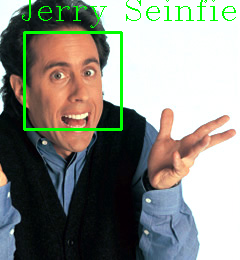

In [15]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
import torch
from torchvision.transforms import ToTensor

haar_cascade = cv.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

people = ['Ben Afflek', 'Elton John', 'Jerry Seinfield', 'Madonna', 'Mindy Kaling']

# Load the model
model = ResNet50(image_channels=3, num_classes=5)
model.load_state_dict(torch.load("/content/resnet50.pth", map_location=torch.device('cpu')))

# Test on the image
img = cv.imread(r'/content/drive/MyDrive/Faces/val/jerry_seinfeld/2.jpg')
faces_rect = haar_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)

for (x,y,w,h) in faces_rect:
    faces_roi = img[y:y+h, x:x+w] # Region of interest
    faces_roi = cv.resize(faces_roi, (224,224), interpolation=cv.INTER_NEAREST) # Resize the image
    faces_roi = ToTensor()(faces_roi) # Convert to tensor
    faces_roi = faces_roi.unsqueeze(0) # Add a batch dimension

    # Pass the image to the model
    model.eval()
    with torch.no_grad():
        preds = model(faces_roi)

    _, predicted = torch.max(preds, dim=1)

    # Get the predicted class probabilities
    probabilities = torch.nn.functional.softmax(preds, dim=1)[0] * 100
    print(f'Label = {people[predicted]} with confidence {probabilities[predicted].item()}%')

    cv.putText(img, str(people[predicted]), (20,20), cv.FONT_HERSHEY_COMPLEX, 1.0, (0, 255, 0), thickness=1)
    cv.rectangle(img, (x,y), (x+w,y+h), (0,255,0), thickness=2)

cv2_imshow(img)
